## **Библиотеки**

In [ ]:
!pip install -U pip setuptools wheel
!pip install -U spacy
!python3 -m spacy download en_core_web_sm

In [111]:
import pandas as pd
import spacy
import re
import numpy as np
import matplotlib.pyplot as plt

from pathlib import Path
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import ComplementNB
from sklearn.experimental import enable_halving_search_cv # разрешаем использование эксперементальных функций
from sklearn.model_selection import HalvingGridSearchCV
from sklearn.model_selection import cross_validate
from sklearn.model_selection import KFold

In [112]:
pd.set_option('max_colwidth', 400)
Random_state = 42

## **Датасет**

In [113]:
data = pd.read_csv('/content/spam-or-not-spam-dataset.zip', encoding='iso-8859-1')[['email', 'label']].rename(columns={'email': 'text'})
data.head() #if an email is spam-1, ham-0.

text  \
0   date wed NUMBER aug NUMBER NUMBER NUMBER NUMBER NUMBER from chris garrigues cwg dated NUMBER NUMBERfaNUMBERd deepeddy com message id NUMBER NUMBER tmda deepeddy vircio com i can t reproduce this error for me it is very repeatable like every time without fail this is the debug log of the pick happening NUMBER NUMBER NUMBER pick_it exec pick inbox list lbrace lbrace subject ftp rbrace rbrace NU...   
1  martin a posted tassos papadopoulos the greek sculptor behind the plan judged that the limestone of mount kerdylio NUMBER miles east of salonika and not far from the mount athos monastic community was ideal for the patriotic sculpture as well as alexander s granite features NUMBER ft high and NUMBER ft wide a museum a restored amphitheatre and car park for admiring crowds are planned so is thi...   
2  man threatens explosion in moscow thursday august NUMBER NUMBER NUMBER NUMBER pm moscow ap security officers on thursday seized an unidentified man who said he was armed with explosives and threatened to blow up his truck in front of russia s federal security services headquarters in moscow ntv television reported the officers seized an automatic rifle the man was carrying then the man got out...   
3  klez the virus that won t die already the most prolific virus ever klez continues to wreak havoc andrew brandt from the september NUMBER issue of pc world magazine posted thursday august NUMBER NUMBER the klez worm is approaching its seventh month of wriggling across the web making it one of the most persistent viruses ever and experts warn that it may be a harbinger of new viruses that use a ...   
4   in adding cream to spaghetti carbonara which has the same effect on pasta as making a pizza a deep pie i just had to jump in here as carbonara is one of my favourites to make and ask what the hell are you supposed to use instead of cream i ve never seen a recipe that hasn t used this personally i use low fat creme fraiche because it works quite nicely but the only time i ve seen an supposedly...   

   label  
0      0  
1      0  
2      0  
3      0  
4      0

In [114]:
data['label'].value_counts()

0    2500
1     500
Name: label, dtype: int64

## Очистка

In [115]:
nlp = spacy.load("en_core_web_sm")
stopwords = nlp.Defaults.stop_words

In [116]:
data['text']= data['text'].astype(str)
data['cleaned_text'] = data['text'].apply(
    lambda x: ' '.join(
        token.lemma_.lower() for token in nlp(x) if
        not token.is_stop
        and not token.is_punct
        and not token.is_digit
        and not token.like_email
        and not token.like_num
        and not token.is_space
    )
)
data.sample(5)

text  \
2808   that s not rush hour traffic it s the flight to safety fixed and indexed annuities are being bought in record numbers as both savers and investors seek strong guarantees and greater upside earnings potential from financially strong companies october is the biggest month for cd rollovers and most cds will roll for one reason habit give your clients a better alternative and take advantage of th...   
2575  dear sir madam if you are fed up of being ripped off by the british government every time you buy your tobacco then you should visit our website where you can now buy NUMBER cartons of cigarettes or NUMBER pouches of rolling tobacco from as little as NUMBER euros approx NUMBER pounds inclusive of delivery by registered air mail from our office in spain why pay more visit our website at URL bes...   
251   quoting kevin lyda kevin dated NUMBER eNUMBER ie suberic net anyone here have experience with windows cvs clients accessing a cvs server securely preferably using ssh of some form putty or cygwin s openssh port and the wincvs client here s something i cobbled together URL cheers i don t like country music but i don t mean to denigrate rick moen those who do and for the people who like country ...   
2465                                                                                    url NUMBER URL date NUMBER NUMBER NUMBERtNUMBER NUMBER NUMBER NUMBER NUMBER upon arriving safely in raleigh our stewardess sang us this to the tune of barney s i love you you love me we love you you love us we re much faster than the bus we hope you ve enjoyed our hos pi tal i ty marry one of us and you ll fly free    
1598                              i m getting no servers available about half the time in the last few days this is with razor NUMBER is there something i need adjust in the installation here or are the servers just down overloaded thanks whit this URL email is sponsored by thinkgeek welcome to geek heaven URL _______________________________________________ razor users mailing list razor users URL URL    

      label  \
2808      1   
2575      1   
251       0   
2465      0   
1598      0   

                                                                                                                                                                                                                                                                                                                                                                                                         cleaned_text  
2808  s rush hour traffic s flight safety fix indexed annuity buy record number saver investor seek strong guarantee great upside earning potential financially strong company october big month cd rollover cd roll reason habit client well alternative advantage window opportunity respond today receive free cd replacement kit number number number numberst application bonus free digital camera capture p...  
2575                                                                                                       dear sir madam feed rip british government time buy tobacco visit website buy number carton cigarette number pouch rolling tobacco little number euro approx number pound inclusive delivery register air mail office spain pay visit website url good regard sale department cheap smoke spain xaynumbery  
251   quote kevin lyda kevin date number enumber ie suberic net experience windows cvs client access cvs server securely preferably ssh form putty cygwin s openssh port wincvs client s cobble url cheer don t like country music don t mean denigrate rick moen people like country music rick url denigrate mean bob newhart irish linux user group ilug url url un subscription information list maintainer li...  
2465                                                                                                                                                                                                       url number url date 

## **Train/test split & fit**

In [117]:
X_train, X_test, y_train, y_test = train_test_split(data['cleaned_text'], data['label'], random_state = Random_state)

## **Countvectorizer**

In [118]:
def custom_tokenize(text):
  text = re.sub(r'[^a-zA-Z ]', '', text)
  return text.split()

In [119]:
vectorizer = CountVectorizer(
    max_df=0.7, # max_df и min_df фильтрует corpus
    min_df=0.007,
    tokenizer=custom_tokenize, # аналогично можно переопределить preprocessor
)

X_train_vectorized = vectorizer.fit_transform(X_train)
X_test_vectorized = vectorizer.transform(X_test)

/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


In [120]:
pd.DataFrame(X_train_vectorized.toarray(), columns=vectorizer.get_feature_names_out()).head()

ability  able  absolute  absolutely  abuse  ac  accept  access  accord  \
0        1     0         0           1      0   0       1       0       0   
1        1     0         0           0      0   0       0       0       0   
2        0     0         0           0      0   0       0       0       0   
3        0     0         0           0      0   0       0       0       0   
4        0     0         0           0      0   0       0       0       0   

   account  ...  xnumber  y  yahoo  yeah  year  yes  yesterday  york  young  \
0        0  ...        0  1      0     0     1    1          0     1      0   
1        0  ...        0  0      0     0     0    0          0     0      0   
2        0  ...        0  0      0     0     0    0          0     0      0   
3        0  ...        0  0      0     0     0    0          0     0      0   
4        0  ...        0  0      0     0     0    0          0     0      0   

   zzzz  
0     0  
1     0  
2     0  
3     0  
4     0  

[5 rows x 1944 columns]

## **Tf-IdfVectorizer**

In [121]:
tfidf_vectorizer = TfidfVectorizer(
    max_df=0.7,
    min_df=0.007,
    tokenizer=custom_tokenize,
)
X_train_tfidf = tfidf_vectorizer.fit_transform(X_train)
X_test_vectorized_tfidf = tfidf_vectorizer.transform(X_test)

/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


In [122]:
pd.DataFrame(X_test_vectorized_tfidf.todense(), columns=tfidf_vectorizer.get_feature_names_out()).head()

ability      able  absolute  absolutely  abuse   ac  accept    access  \
0      0.0  0.000000       0.0         0.0    0.0  0.0     0.0  0.000000   
1      0.0  0.043438       0.0         0.0    0.0  0.0     0.0  0.000000   
2      0.0  0.000000       0.0         0.0    0.0  0.0     0.0  0.000000   
3      0.0  0.000000       0.0         0.0    0.0  0.0     0.0  0.127927   
4      0.0  0.000000       0.0         0.0    0.0  0.0     0.0  0.000000   

   accord  account  ...  xnumber    y  yahoo  yeah  year  yes  yesterday  \
0     0.0      0.0  ...      0.0  0.0    0.0   0.0   0.0  0.0        0.0   
1     0.0      0.0  ...      0.0  0.0    0.0   0.0   0.0  0.0        0.0   
2     0.0      0.0  ...      0.0  0.0    0.0   0.0   0.0  0.0        0.0   
3     0.0      0.0  ...      0.0  0.0    0.0   0.0   0.0  0.0        0.0   
4     0.0      0.0  ...      0.0  0.0    0.0   0.0   0.0  0.0        0.0   

   york  young  zzzz  
0   0.0    0.0   0.0  
1   0.0    0.0   0.0  
2   0.0    0.0   0.0  
3   0.0    0.0   0.0  
4   0.0    0.0   0.0  

[5 rows x 1944 columns]

##**Сравнение CountVectorizer и TfidfVectorizer**

In [123]:
pipe_CountVectorizer = Pipeline(
    steps=[
        ('tfidf', CountVectorizer()),
        ('clf', LogisticRegression(random_state=Random_state))
    ]
).fit(X_train, y_train)

preds = pipe_CountVectorizer.predict(X_test)
print(classification_report(y_test, preds))

              precision    recall  f1-score   support

           0       0.99      1.00      0.99       624
           1       0.97      0.93      0.95       126

    accuracy                           0.98       750
   macro avg       0.98      0.96      0.97       750
weighted avg       0.98      0.98      0.98       750



In [124]:
pipe_tfidf = Pipeline(
    steps=[
        ('tfidf', TfidfVectorizer()),
        ('clf', LogisticRegression(random_state=Random_state))
    ]
).fit(X_train, y_train)

preds = pipe_tfidf.predict(X_test)
print(classification_report(y_test, preds))

              precision    recall  f1-score   support

           0       0.95      1.00      0.98       624
           1       1.00      0.76      0.86       126

    accuracy                           0.96       750
   macro avg       0.98      0.88      0.92       750
weighted avg       0.96      0.96      0.96       750



### **Вывод**

CountVectorizer - преобразует текст в матрицу и в каждой ячейке матрицы записывается количество вхождений слова в соответствующем документе. Этот метод не учитывает важность слова в контексте корпуса текстов.

TfidfVectorizer - также преобразует текст в матрицу, но вместо простого количества вхождений слов учитывает важность слова с учетом его частоты в документе и обратной частоты в документах корпуса текстов.

В данном случае CountVectorizer показал более высокие резульатыт по сравнению с TfidfVectorizer.

## **Сравнение DecisionTreeClassifier, LogisticRegression, Naive Bayes**

In [125]:
splitter = KFold(n_splits=5, shuffle=True, random_state=Random_state)

### **DecisionTreeClassifier**

In [126]:
pipe_DecisionTreeClassifier = Pipeline(
    steps=[
        ('tfidf', TfidfVectorizer()),
        ('clf', DecisionTreeClassifier(random_state=Random_state)),
    ]
)

In [127]:
DecisionTreeClassifier_parameter_grid = {
    'clf__criterion': ['gini', 'entropy'],
    'clf__max_depth': (None, 10, 50, 100),
    'clf__min_samples_split': (2, 5, 10, 15),
    'clf__min_samples_leaf': (1, 2, 4)
}

In [128]:
grid_search_pipe_DecisionTreeClassifier = HalvingGridSearchCV(
    pipe_DecisionTreeClassifier,
    param_grid=DecisionTreeClassifier_parameter_grid,
    n_jobs=-1,
    verbose=1,
    cv=splitter,
    scoring='f1',
    random_state=Random_state,
)
grid_search_pipe_DecisionTreeClassifier.fit(X_train, y_train)

n_iterations: 5
n_required_iterations: 5
n_possible_iterations: 5
min_resources_: 27
max_resources_: 2250
aggressive_elimination: False
factor: 3
----------
iter: 0
n_candidates: 96
n_resources: 27
Fitting 5 folds for each of 96 candidates, totalling 480 fits
----------
iter: 1
n_candidates: 32
n_resources: 81
Fitting 5 folds for each of 32 candidates, totalling 160 fits
----------
iter: 2
n_candidates: 11
n_resources: 243
Fitting 5 folds for each of 11 candidates, totalling 55 fits
----------
iter: 3
n_candidates: 4
n_resources: 729
Fitting 5 folds for each of 4 candidates, totalling 20 fits
----------
iter: 4
n_candidates: 2
n_resources: 2187
Fitting 5 folds for each of 2 candidates, totalling 10 fits


HalvingGridSearchCV(cv=KFold(n_splits=5, random_state=42, shuffle=True),
                    estimator=Pipeline(steps=[('tfidf', TfidfVectorizer()),
                                              ('clf',
                                               DecisionTreeClassifier(random_state=42))]),
                    n_jobs=-1,
                    param_grid={'clf__criterion': ['gini', 'entropy'],
                                'clf__max_depth': (None, 10, 50, 100),
                                'clf__min_samples_leaf': (1, 2, 4),
                                'clf__min_samples_split': (2, 5, 10, 15)},
                    random_state=42, scoring='f1', verbose=1)

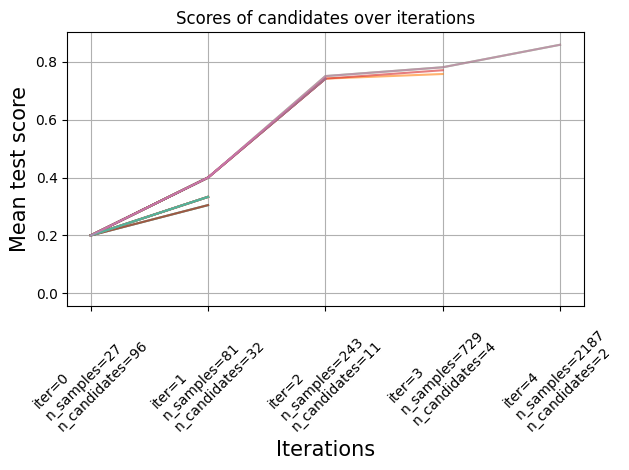

In [129]:
results = pd.DataFrame(grid_search_pipe_DecisionTreeClassifier.cv_results_)
results["params_str"] = results.params.apply(str)
results.drop_duplicates(subset=("params_str", "iter"), inplace=True)
mean_scores = results.pivot(
    index="iter",
    columns="params_str",
     values="mean_test_score",
)
ax = mean_scores.plot(legend=False, alpha=0.6)

labels = [
    f"iter={i}\nn_samples={grid_search_pipe_DecisionTreeClassifier.n_resources_[i]}\nn_candidates={grid_search_pipe_DecisionTreeClassifier.n_candidates_[i]}"
    for i in range(grid_search_pipe_DecisionTreeClassifier.n_iterations_)
]

ax.set_xticks(range(grid_search_pipe_DecisionTreeClassifier.n_iterations_))
ax.set_xticklabels(labels, rotation=45, multialignment="left")
ax.set_title("Scores of candidates over iterations")
ax.set_ylabel("Mean test score", fontsize=15)
ax.set_xlabel("Iterations", fontsize=15)
plt.tight_layout()
plt.grid()
plt.show()

In [130]:
grid_search_pipe_DecisionTreeClassifier.best_params_

{'clf__criterion': 'gini',
 'clf__max_depth': 100,
 'clf__min_samples_leaf': 1,
 'clf__min_samples_split': 2}

In [131]:
print(classification_report(y_test, grid_search_pipe_DecisionTreeClassifier.best_estimator_.predict(X_test)))

              precision    recall  f1-score   support

           0       0.98      0.96      0.97       624
           1       0.82      0.90      0.86       126

    accuracy                           0.95       750
   macro avg       0.90      0.93      0.92       750
weighted avg       0.95      0.95      0.95       750



### **LogisticRegression**

In [132]:
pipe_logisticRegression = Pipeline(
    steps=[
        ('tfidf', TfidfVectorizer()),
        ('clf', LogisticRegression(random_state=Random_state))
    ]
)

In [133]:
logisticRegression_parameter_grid = {
    'clf__penalty': ['l1', 'l2'],
    'clf__solver': ['liblinear', 'saga'],
    'clf__fit_intercept': (False, True),
    'clf__C': [0.01, 0.1, 1, 10],
}

In [134]:
grid_search_logisticRegression = HalvingGridSearchCV(
    pipe_logisticRegression,
    param_grid=logisticRegression_parameter_grid,
    n_jobs=-1,
    verbose=1,
    cv=splitter,
    scoring='f1',
    random_state=Random_state,
)
grid_search_logisticRegression.fit(X_train, y_train)

n_iterations: 4
n_required_iterations: 4
n_possible_iterations: 4
min_resources_: 83
max_resources_: 2250
aggressive_elimination: False
factor: 3
----------
iter: 0
n_candidates: 32
n_resources: 83
Fitting 5 folds for each of 32 candidates, totalling 160 fits
----------
iter: 1
n_candidates: 11
n_resources: 249
Fitting 5 folds for each of 11 candidates, totalling 55 fits
----------
iter: 2
n_candidates: 4
n_resources: 747
Fitting 5 folds for each of 4 candidates, totalling 20 fits
----------
iter: 3
n_candidates: 2
n_resources: 2241
Fitting 5 folds for each of 2 candidates, totalling 10 fits


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


HalvingGridSearchCV(cv=KFold(n_splits=5, random_state=42, shuffle=True),
                    estimator=Pipeline(steps=[('tfidf', TfidfVectorizer()),
                                              ('clf',
                                               LogisticRegression(random_state=42))]),
                    n_jobs=-1,
                    param_grid={'clf__C': [0.01, 0.1, 1, 10],
                                'clf__fit_intercept': (False, True),
                                'clf__penalty': ['l1', 'l2'],
                                'clf__solver': ['liblinear', 'saga']},
                    random_state=42, scoring='f1', verbose=1)

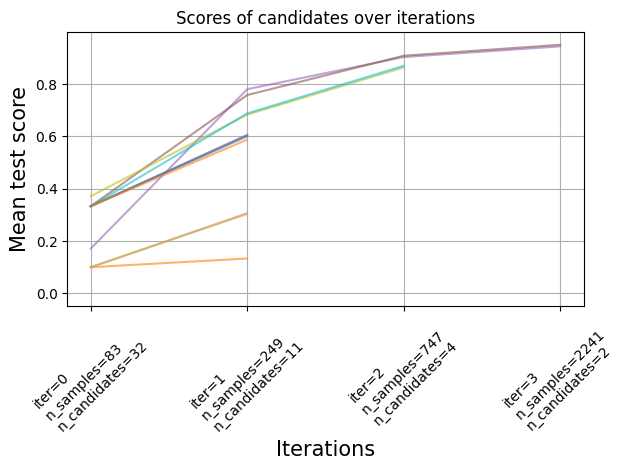

In [135]:
results = pd.DataFrame(grid_search_logisticRegression.cv_results_)
results["params_str"] = results.params.apply(str)
results.drop_duplicates(subset=("params_str", "iter"), inplace=True)
mean_scores = results.pivot(
    index="iter",
    columns="params_str",
     values="mean_test_score",
)
ax = mean_scores.plot(legend=False, alpha=0.6)

labels = [
    f"iter={i}\nn_samples={grid_search_logisticRegression.n_resources_[i]}\nn_candidates={grid_search_logisticRegression.n_candidates_[i]}"
    for i in range(grid_search_logisticRegression.n_iterations_)
]

ax.set_xticks(range(grid_search_logisticRegression.n_iterations_))
ax.set_xticklabels(labels, rotation=45, multialignment="left")
ax.set_title("Scores of candidates over iterations")
ax.set_ylabel("Mean test score", fontsize=15)
ax.set_xlabel("Iterations", fontsize=15)
plt.tight_layout()
plt.grid()
plt.show()

In [136]:
grid_search_logisticRegression.best_params_

{'clf__C': 10,
 'clf__fit_intercept': False,
 'clf__penalty': 'l1',
 'clf__solver': 'saga'}

In [137]:
print(classification_report(y_test, grid_search_logisticRegression.best_estimator_.predict(X_test)))

              precision    recall  f1-score   support

           0       0.98      0.99      0.99       624
           1       0.94      0.92      0.93       126

    accuracy                           0.98       750
   macro avg       0.96      0.95      0.96       750
weighted avg       0.98      0.98      0.98       750



### **Naive Bayes**

In [139]:
pipe_complement_NB = Pipeline(
    steps=[
        ('tfidf', TfidfVectorizer()),
        ('clf', ComplementNB()),
    ]
)

In [140]:
complementNB_parameter_grid = {
    'clf__alpha': np.linspace(0.0, 0,5, 1, 3),
    'clf__fit_prior': (False, True),
    'clf__norm': (False, True)
}

In [141]:
grid_search_complement_NB = HalvingGridSearchCV(
    pipe_complement_NB,
    param_grid=complementNB_parameter_grid,
    n_jobs=-1,
    verbose=1,
    cv=splitter,
    scoring='f1',
    random_state=Random_state,
)
grid_search_complement_NB.fit(X_train, y_train)

n_iterations: 2
n_required_iterations: 2
n_possible_iterations: 2
min_resources_: 750
max_resources_: 2250
aggressive_elimination: False
factor: 3
----------
iter: 0
n_candidates: 8
n_resources: 750
Fitting 5 folds for each of 8 candidates, totalling 40 fits


/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:378: FitFailedWarning: 
20 fits failed out of a total of 40.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
4 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/pipeline.py", line 405, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/naive_bayes.py", line 777, in fit
    alpha = self._check_alpha()
  File "/usr/local/lib/python3.10/dist-packages

----------
iter: 1
n_candidates: 3
n_resources: 2250
Fitting 5 folds for each of 3 candidates, totalling 15 fits


/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_search.py:952: UserWarning: One or more of the test scores are non-finite: [       nan        nan        nan        nan 0.81411215 0.66692943
 0.81411215 0.66692943 0.85403768 0.86429175 0.86429175]
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_search.py:952: UserWarning: One or more of the train scores are non-finite: [       nan        nan        nan        nan 1.         0.94917932
 1.         0.94917932 0.95714781 0.99733393 0.99733393]
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/naive_bayes.py:629: FutureWarning: The default value for `force_alpha` will change to `True` in 1.4. To suppress this warning, manually set the value of `force_alpha`.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/naive_bayes.py:635: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10. Use `force_alpha=True` to keep alpha unchanged.
  w

HalvingGridSearchCV(cv=KFold(n_splits=5, random_state=42, shuffle=True),
                    estimator=Pipeline(steps=[('tfidf', TfidfVectorizer()),
                                              ('clf', ComplementNB())]),
                    n_jobs=-1,
                    param_grid={'clf__alpha': (array([0., 0., 0., 0., 0.]),
                                               0.0),
                                'clf__fit_prior': (False, True),
                                'clf__norm': (False, True)},
                    random_state=42, scoring='f1', verbose=1)

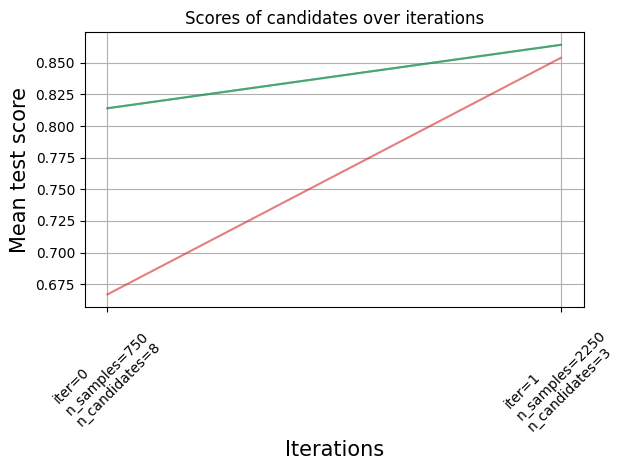

In [142]:
results = pd.DataFrame(grid_search_complement_NB.cv_results_)
results["params_str"] = results.params.apply(str)
results.drop_duplicates(subset=("params_str", "iter"), inplace=True)
mean_scores = results.pivot(
    index="iter",
    columns="params_str",
     values="mean_test_score",
)
ax = mean_scores.plot(legend=False, alpha=0.6)

labels = [
    f"iter={i}\nn_samples={grid_search_complement_NB.n_resources_[i]}\nn_candidates={grid_search_complement_NB.n_candidates_[i]}"
    for i in range(grid_search_complement_NB.n_iterations_)
]

ax.set_xticks(range(grid_search_complement_NB.n_iterations_))
ax.set_xticklabels(labels, rotation=45, multialignment="left")
ax.set_title("Scores of candidates over iterations")
ax.set_ylabel("Mean test score", fontsize=15)
ax.set_xlabel("Iterations", fontsize=15)
plt.tight_layout()
plt.grid()
plt.show()

In [143]:
grid_search_complement_NB.best_params_

{'clf__alpha': 0.0, 'clf__fit_prior': False, 'clf__norm': False}

In [144]:
print(classification_report(y_test, grid_search_complement_NB.best_estimator_.predict(X_test)))

              precision    recall  f1-score   support

           0       0.97      1.00      0.98       624
           1       0.98      0.83      0.90       126

    accuracy                           0.97       750
   macro avg       0.97      0.91      0.94       750
weighted avg       0.97      0.97      0.97       750



#### **Вывод**

**DecisionTreeClassifier** - дерево решений представляет собой древовидную структуру, в которой каждый узел представляет собой тестовое условие, а каждый лист - прогнозное значение (класс).

**LogisticRegression** - модель предсказывает вероятность принадлежности объекта к одному из классов на основе линейной комбинации признаков.

**Naive Bayes** - модификация классического Multinomial Naive Bayes, разработанной специально для работы с несбалансированными текстовыми данными. Предполагает, что признаки (слова в тексте) независимы.

Так как мы ищем спам, то стоит выделить приоритет для 1 класса (spam). Лучший результат показывает LogisticRegression у котрого f1-score составляет 0.93.